In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import tarfile
# from tqdm import tqdm, tqdm_notebook, tnrange
# import json
import time

In [154]:
ratings = pd.read_csv('ratings.csv')
restau = pd.read_csv('restaurants.csv')
users = pd.read_csv('users.csv')

In [155]:
ratings.shape, restau.shape, users.shape

((2674005, 5), (44594, 11), (281334, 11))

In [156]:
matches = ['[r|R]estaurant']
matches_regex = "|".join(matches)
matches_bools = restau.categories.str.contains(matches_regex, regex=True)
restau_tmp = restau[matches_bools]

In [157]:
ratings_tmp = pd.merge(ratings, restau_tmp, on="business_id", how='inner')

In [158]:
ratings_tmp.drop(restau_tmp.columns[1:], axis=1, inplace=True)

In [159]:
user_ids_tmp = list(ratings_tmp['user_id'].unique())

In [160]:
users_tmp = users[users['user_id'].isin(user_ids_tmp)]

In [161]:
users_tmp.reset_index(inplace=True, drop=True)

In [162]:
ratings_tmp.shape, restau_tmp.shape, users_tmp.shape

((2436261, 5), (35004, 11), (279453, 11))

# Cleaning Data

## Drop Restaurants with Invalid States

In [163]:
restau_tmp = restau_tmp.drop(restau_tmp[restau_tmp['business_state'].isin(['HI','XMS'])].index)

In [164]:
# restau_tmp['']

## Drop Restaurants having less than 15 reviews

In [165]:
restau_tmp['review_counts'].describe()

count    35002.000000
mean       104.103108
std        220.551772
min          5.000000
25%         16.000000
50%         40.000000
75%        109.000000
max       7568.000000
Name: review_counts, dtype: float64

In [166]:
len(restau_tmp)

35002

In [167]:
len(restau_tmp[restau_tmp['review_counts']<=15])

8619

In [168]:
restau_tmp = restau_tmp.drop(restau_tmp[restau_tmp['review_counts']<=15].index)

In [169]:
restau_tmp.reset_index(drop=True, inplace=True)

In [170]:
restau_tmp.shape

(26383, 11)

## Drop users having less ratings

In [171]:
user_rating_count = ratings_tmp.groupby('user_id').size()

In [172]:
user_rating_avg = ratings_tmp.groupby('user_id')['rating'].mean()

In [174]:
users_tmp['ratings_count'] = users_tmp['user_id'].apply(lambda x: user_rating_count[x])
users_tmp['ratings_avg'] = users_tmp['user_id'].apply(lambda x: user_rating_avg[x])

C:\Users\Om Mali\AppData\Local\Temp\ipykernel_18924\2791658394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_tmp['ratings_count'] = users_tmp['user_id'].apply(lambda x: user_rating_count[x])
C:\Users\Om Mali\AppData\Local\Temp\ipykernel_18924\2791658394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_tmp['ratings_avg'] = users_tmp['user_id'].apply(lambda x: user_rating_avg[x])


In [175]:
len(users_tmp)

279453

In [176]:
users_tmp.head()

,user_id,user_name,user_review_count,user_yelp_since,friends,useful_reviews,funny_reviews,cool_reviews,n_fans,years_elite,average_stars,ratings_count,ratings_avg
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",7217,1259,5994,267,2007,3.91,6,4.166667
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",43091,13066,27281,3138,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3.74,21,3.952381
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",2086,1010,1003,52,"2009,2010,2011,2012,2013",3.32,8,3.125000
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",512,330,299,28,"2009,2010,2011",4.27,6,4.333333
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",29,15,7,1,NaN,3.54,10,3.600000


In [177]:
# Drop users that have less reviews.
len(users_tmp[(users_tmp['user_review_count']<=10)])

71686

In [178]:
# Drop users that have less reviews as more reviews tends to mean that they are reliable.
users_tmp = users_tmp.drop(users_tmp[users_tmp['user_review_count'] <=10].index)

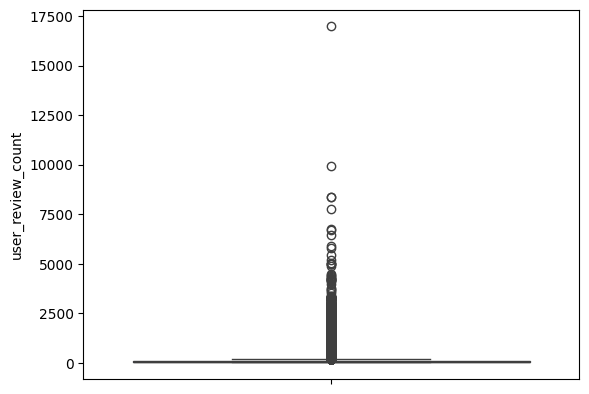

In [180]:
sns.boxplot(users_tmp[users_tmp['ratings_count']<100]['user_review_count']);

In [181]:
len(users_tmp)

207767

In [182]:
len(users_tmp[((users_tmp['useful_reviews'] / users_tmp['user_review_count'])*100 )< 20])

14750

In [183]:
users_tmp.head()

,user_id,user_name,user_review_count,user_yelp_since,friends,useful_reviews,funny_reviews,cool_reviews,n_fans,years_elite,average_stars,ratings_count,ratings_avg
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",7217,1259,5994,267,2007,3.91,6,4.166667
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",43091,13066,27281,3138,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3.74,21,3.952381
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",2086,1010,1003,52,"2009,2010,2011,2012,2013",3.32,8,3.125000
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",512,330,299,28,"2009,2010,2011",4.27,6,4.333333
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",29,15,7,1,NaN,3.54,10,3.600000


In [186]:
len(users_tmp)

207767

In [187]:
len(users_tmp[users_tmp['user_review_count']<=10])

0

In [189]:
ratings_tmp.head()

,user_id,business_id,rating,date,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
1,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-05-13 17:06:55,This is the second time we tried turning point...
2,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,2017-08-08 00:58:18,The place is cute and the staff was very frien...
3,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2017-11-19 02:20:23,We came on a Saturday morning after waiting a ...
4,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-09-09 17:49:47,"Mediocre at best. The decor is very nice, and ..."


In [191]:
users_tmp['user_id'].nunique(), ratings_tmp['user_id'].nunique()

(207767, 279453)

In [193]:
ratings_tmp.shape

(2436261, 5)

In [192]:
ratings_tmp1 = ratings_tmp.copy()

In [194]:
ratings_tmp = pd.merge(ratings_tmp, users_tmp, on='user_id')

In [195]:
ratings_tmp.shape

(2187283, 17)

In [198]:
ratings_tmp.drop(users_tmp.columns[1:], axis=1, inplace=True)

In [200]:
ratings_tmp.shape, users_tmp['user_id'].nunique(), ratings_tmp['user_id'].nunique()

((2187283, 5), 207767, 207767)

## Removing branches of same restaurant

In [201]:
ratings_tmp = pd.merge(ratings_tmp, restau_tmp, on="business_id", how='inner')

In [202]:
ratings_tmp.drop(restau_tmp.columns[1:], axis=1, inplace=True)

In [203]:
len(ratings_tmp)

2139709

In [204]:
ratings_tmp.head()

,user_id,business_id,rating,date,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
1,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,2017-08-08 00:58:18,The place is cute and the staff was very frien...
2,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2017-11-19 02:20:23,We came on a Saturday morning after waiting a ...
3,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-09-09 17:49:47,"Mediocre at best. The decor is very nice, and ..."
4,gy7Ss1uTpCjbbGsghTvNsw,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-07-29 17:12:27,When I was shown to my seat of was still wet s...


In [205]:
ratings_tmp.shape, restau_tmp.shape, users_tmp.shape

((2139709, 5), (26383, 11), (207767, 13))

In [206]:
ratings_tmp['business_id'].nunique()

26383

In [207]:
ratings_tmp = pd.merge(ratings_tmp, restau_tmp[['business_id', 'business_name']], on='business_id')

In [208]:
ratings_tmp['business_name'] = ratings_tmp['business_name'].apply(lambda x: x.lower())

In [209]:
ratings_grpby = ratings_tmp.groupby(['business_name'])

In [210]:
restau_first_id_mapper = ratings_grpby['business_id'].first()

In [211]:
ratings_tmp['business_id'] = ratings_tmp.apply(lambda row: restau_first_id_mapper[row['business_name']], axis=1)

In [212]:
ratings_tmp['business_id'].nunique()

18717

In [213]:
ratings_tmp.head()

,user_id,business_id,rating,date,text,business_name
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",turning point of north wales
1,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,2017-08-08 00:58:18,The place is cute and the staff was very frien...,turning point of north wales
2,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2017-11-19 02:20:23,We came on a Saturday morning after waiting a ...,turning point of north wales
3,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-09-09 17:49:47,"Mediocre at best. The decor is very nice, and ...",turning point of north wales
4,gy7Ss1uTpCjbbGsghTvNsw,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-07-29 17:12:27,When I was shown to my seat of was still wet s...,turning point of north wales


## Removing Past Reviews

In [214]:
ratings_tmp[['user_id', 'business_id', 'rating']].duplicated().sum()

66418

In [215]:
len(ratings_tmp)

2139709

In [216]:
ratings_tmp['date'] = pd.to_datetime(ratings_tmp['date'])

In [217]:
np.where(ratings_tmp[['user_id', 'business_id', 'rating']].duplicated())

(array([      5,      13,     110, ..., 2139641, 2139654, 2139690],
       dtype=int64),)

In [218]:
# ratings.iloc[[2163]]
ratings_tmp[(ratings_tmp['user_id']=='A_TznMSVvVb6tbiGSvRQ_Q') & 
               (ratings_tmp['business_id']=='G-zzByEfv2oqjcxYmPsjtA')]

,user_id,business_id,rating,date,text,business_name
554385,A_TznMSVvVb6tbiGSvRQ_Q,G-zzByEfv2oqjcxYmPsjtA,5.0,2016-04-23 04:09:45,Updated to 5 stars. They expanded the place w...,el limon - malvern
554386,A_TznMSVvVb6tbiGSvRQ_Q,G-zzByEfv2oqjcxYmPsjtA,5.0,2014-09-25 18:04:21,Really great food and people. Super small cas...,el limon - malvern


In [219]:
ratings_tmp[(ratings_tmp['user_id']=='A_TznMSVvVb6tbiGSvRQ_Q') & 
               (ratings_tmp['business_id']=='G-zzByEfv2oqjcxYmPsjtA')].sort_values('date').drop_duplicates(
['user_id', 'business_id'], keep='last')

,user_id,business_id,rating,date,text,business_name
554385,A_TznMSVvVb6tbiGSvRQ_Q,G-zzByEfv2oqjcxYmPsjtA,5.0,2016-04-23 04:09:45,Updated to 5 stars. They expanded the place w...,el limon - malvern


In [220]:
ratings_tmp = ratings_tmp.sort_values('date').drop_duplicates(['user_id', 'business_id'], keep='last')

In [221]:
ratings_tmp[['user_id', 'business_id', 'rating']].duplicated().sum()

0

In [222]:
ratings_tmp.shape, restau_tmp.shape, users_tmp.shape

((2016310, 6), (26383, 11), (207767, 13))

In [223]:
users_tmp['user_id'].nunique(), ratings_tmp['user_id'].nunique()

(207767, 207581)

In [229]:
users_set = set(ratings_tmp['user_id'].unique())

In [232]:
users_tmp = users_tmp[users_tmp['user_id'].isin(users_set)]

In [233]:
users_tmp['user_id'].nunique(), ratings_tmp['user_id'].nunique()

(207581, 207581)

In [224]:
restau_tmp['business_id'].nunique(), ratings_tmp['business_id'].nunique()

(26383, 18717)

In [225]:
len(restau_first_id_mapper)

18717

In [226]:
restau_no_dupl = restau_tmp[restau_tmp.apply(lambda row: restau_first_id_mapper[row['business_name'].lower()] == row['business_id'], axis=1)]

In [234]:
restau_no_dupl['business_id'].nunique(), ratings_tmp['business_id'].nunique()

(18717, 18717)

In [239]:
ratings_tmp.shape, restau_no_dupl.shape, users_tmp.shape

((2016310, 6), (18717, 11), (207581, 13))

In [241]:
ratings_tmp.to_csv('ratings_processed.csv',index=False)
restau_tmp.to_csv('restau_processed.csv',index=False)
users_tmp.to_csv('users_processed.csv',index=False)
restau_no_dupl.to_csv('restau_processed_no_duplicate.csv', index=False)

In [242]:
# ratings = ratings_tmp.copy()
# restau = restau_tmp.copy()
# users = users_tmp.copy()

ratings = pd.read_csv('ratings_processed.csv')
restau = pd.read_csv('restau_processed_no_duplicate.csv')
users = pd.read_csv('users_processed.csv')


In [247]:
ratings_tmp1 = ratings.copy()
restau_tmp1 = restau.copy()
users_tmp1 = users.copy()

C:\Users\Om Mali\AppData\Local\Temp\ipykernel_18924\1369355405.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(users.corr());


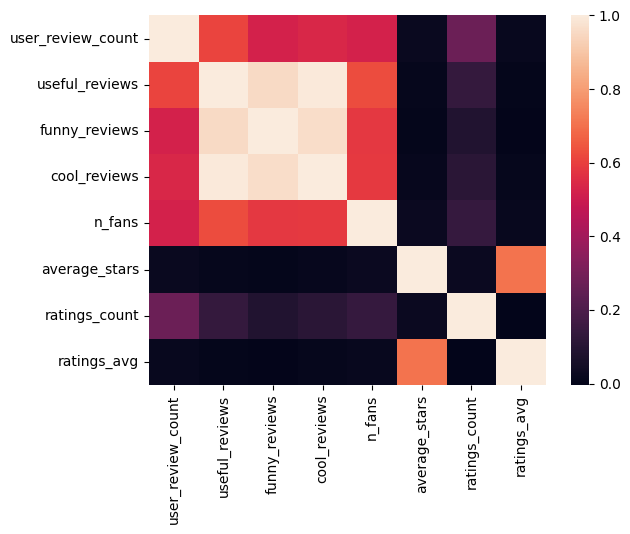

In [291]:
sns.heatmap(users.corr());

# Sampling

In [146]:
SAMPLING_RATE = 1/10

In [147]:
# Downsample by users
user_id_unique = ratings.user_id.unique()
user_id_sample = pd.DataFrame(user_id_unique, columns=['unique_user_id']) \
                    .sample(frac= SAMPLING_RATE, replace=False, random_state=0)

ratings_sample = ratings.merge(user_id_sample, left_on='user_id', right_on='unique_user_id') \
                    .drop(['unique_user_id'], axis=1)

In [149]:
len(ratings)

2016310

In [199]:
ratings_sample['user_id'].nunique()

20758

In [200]:
restau_id_sample = ratings_sample['business_id'].unique()

In [205]:
restau_sample = restau[restau['business_id'].isin(restau_id_sample)]

In [216]:
users_sample = users[users['user_id'].isin(set(user_id_sample['unique_user_id']))]

In [217]:
user_sample_idx_to_id_mapper = {}
user_sample_id_to_idx_mapper = {}

for row in users_sample.iterrows():
#     print(row)
    user_sample_idx_to_id_mapper[row[0]] = row[1][0]
    user_sample_id_to_idx_mapper[row[1][0]] = row[0]
#     print(row[0])

restau_sample_idx_to_id_mapper = {}
restau_sample_id_to_idx_mapper = {}

for row in restau_sample.iterrows():
#     print(row)
    restau_sample_idx_to_id_mapper[row[0]] = (row[1][0], row[1][1])
    restau_sample_id_to_idx_mapper[row[1][0]] = row[0]

In [219]:
restau_sample_tmp = restau_sample.copy()
ratings_sample_tmp = ratings_sample.copy()

In [222]:
ratings_sample_tmp['user_id'] = ratings_sample_tmp['user_id'].apply(lambda x: user_sample_id_to_idx_mapper[x])
ratings_sample_tmp['business_id'] = ratings_sample_tmp['business_id'].apply(lambda x: restau_sample_id_to_idx_mapper[x])
restau_sample_tmp['business_id'] = restau_sample_tmp['business_id'].apply(lambda x: restau_sample_id_to_idx_mapper[x])

ratings_sample_tmp.to_csv('ratings_sample_int.csv', index=False)
restau_sample_tmp.to_csv('restau_sample_int.csv', index=False)

In [218]:
import pickle

with open('user_sample_idx_to_id_mapper.pickle', 'wb') as handle:
    pickle.dump(user_sample_idx_to_id_mapper, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('user_sample_id_to_idx_mapper.pickle', 'wb') as handle:
    pickle.dump(user_sample_id_to_idx_mapper, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('restau_sample_idx_to_id_mapper.pickle', 'wb') as handle:
    pickle.dump(restau_sample_idx_to_id_mapper, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('restau_sample_id_to_idx_mapper.pickle', 'wb') as handle:
    pickle.dump(restau_sample_id_to_idx_mapper, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [150]:
ratings_sample.shape

(201480, 6)

In [84]:
ratings_svd = ratings_sample.pivot(index="user_id", columns="business_id", values="rating").fillna(0)

In [85]:
ratings_svd.shape,ratings_svd.shape[0]*ratings_svd.shape[1] 

((13948, 15902), 221801096)

In [86]:
ratings_size = ratings_svd.shape[0]*ratings_svd.shape[1]
print('Sparsity: ', (1 - np.count_nonzero(ratings_svd)/ratings_size)*100 )

Sparsity:  99.94750431711122


In [112]:
print(ratings.columns)
print(users.columns)
print(restau.columns)

Index(['user_id', 'business_id', 'rating', 'date', 'text'], dtype='object')
Index(['user_id', 'user_name', 'user_review_count', 'user_yelp_since',
       'friends', 'useful_reviews', 'funny_reviews', 'cool_reviews', 'n_fans',
       'years_elite', 'average_stars', 'ratings_count', 'ratings_avg'],
      dtype='object')
Index(['business_id', 'business_name', 'business_address', 'business_city',
       'business_state', 'business_latitude', 'business_longitude', 'stars',
       'review_counts', 'is_open', 'categories'],
      dtype='object')


# SVD

In [20]:
from surprise import SVD, accuracy
# from surprise.model_selection import train_test_split
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (
    rmse,
    mae,
    rsquared,
    exp_var,
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    get_top_k_items,
)
from recommenders.models.surprise.surprise_utils import (
    predict,
    compute_ranking_predictions,
)

In [151]:
svd_train, svd_test = python_random_split(ratings_sample[["user_id", "business_id", "rating"]], 0.75)

In [152]:
reader = Reader(rating_scale=(1, 5))

In [153]:
surprise_svd_train = Dataset.load_from_df(svd_train[["user_id", "business_id", "rating"]], reader).build_full_trainset()

In [176]:
surprise_svd = SVD(random_state=0, n_factors=200, n_epochs=20, verbose=True)
surprise_svd.fit(surprise_svd_train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [177]:
surprise_svd_predictions = predict(surprise_svd, svd_test, usercol="user_id", itemcol="business_id")
surprise_svd_predictions.head()

,user_id,business_id,prediction
0,YcSDGPRj-cmmadlaJLTyqw,YeMouev-sLfAxykmcANNoQ,3.897302
1,KuH_bH5Hie9yWtTJzSANgA,iCCSlTTZTzhpmhBO79CoYA,3.825349
2,XZC1oFBJlYwv1sGrhu9Jew,5THN_NeVZlyQ1Lx89hUAVA,3.700723
3,C29mwZb95W3BDDaz2apFUg,6xA3Zg26SbaftWvzf6Rn4Q,4.443380
4,lfr9EmgZT89_Rlf8X8pRow,vuM_e7niXcspLooTVZNXPQ,2.710934


In [179]:
surprise_svd_predictions = pd.merge(surprise_svd_predictions, svd_test, on=['user_id', 'business_id'])

In [180]:
surprise_svd_predictions.head()

,user_id,business_id,prediction,rating
0,YcSDGPRj-cmmadlaJLTyqw,YeMouev-sLfAxykmcANNoQ,3.897302,3.0
1,KuH_bH5Hie9yWtTJzSANgA,iCCSlTTZTzhpmhBO79CoYA,3.825349,4.0
2,XZC1oFBJlYwv1sGrhu9Jew,5THN_NeVZlyQ1Lx89hUAVA,3.700723,5.0
3,C29mwZb95W3BDDaz2apFUg,6xA3Zg26SbaftWvzf6Rn4Q,4.443380,5.0
4,lfr9EmgZT89_Rlf8X8pRow,vuM_e7niXcspLooTVZNXPQ,2.710934,5.0


In [181]:
threshold = 3.5

In [182]:
surprise_svd_predictions.sort_values(by='prediction',ascending=False,inplace=True)

In [183]:
surprise_svd_predictions['y_actual'] = surprise_svd_predictions['rating'] >= threshold
surprise_svd_predictions['y_recommended'] = surprise_svd_predictions['prediction'] >= threshold

In [184]:
surprise_svd_predictions['hit'] = surprise_svd_predictions['y_actual'] & surprise_svd_predictions['y_recommended']

In [185]:
surprise_svd_predictions['hit'] = surprise_svd_predictions['hit'].apply(lambda x: 1 if x else 0)

In [186]:
surprise_svd_predictions.head()

,user_id,business_id,prediction,rating,y_actual,y_recommended,hit
33289,ckFC2OotVWf7jPZg2f4JJQ,K7KHmHzxNwzqiijSJeKe_A,5.0,5.0,True,True,1
20110,SdHs1J0L41fbxcxKJJ-NFQ,UbFkHiEt9S-0mUL3RQ5Ghg,5.0,5.0,True,True,1
40570,ZDCWEctaQHfJQT1sH_rMmA,lu2UpRHLBZfvLG_caNEHKQ,5.0,5.0,True,True,1
33818,nR9klq6eOdBuA_cSZW3HqQ,LmsFBarEMorpSyw2vEwRAA,5.0,5.0,True,True,1
10138,TxA-1cobm2MnIyn6kHnnQQ,GXFMD0Z4jEVZBCsbPf4CTQ,5.0,5.0,True,True,1


In [119]:
def mean_reciprocal_rank(rs):
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

def r_precision(r):
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def eval_metrics(df, max_k):
    precision_k = {}
    # recall_k = {}
    ndcg_k = {}
    
    unique_users = set(df['user_id'].unique())
    hit_arrays = []
    
    for user in unique_users:
        hit_arr = df[df['user_id']==user]['hit']
        # df_user = df[df['user_id']==user][['y_actual', 'y_recommended']]
        max_user_k = min(max_k, len(hit_arr))

        for k in range(1, max_user_k+1):
#             prec = precision_at_k(df_user, k, 'y_actual', 'y_recommended')
            # rec = recall_at_k(df_user, k, 'y_actual', 'y_recommended')
            prec = precision_at_k(hit_arr, k)
#             rec = recall_at_k(df_user, k)
            ndcg = ndcg_at_k(hit_arr, k)
            
            if k in precision_k.keys():
                precision_k[k].append(prec)
                # recall_k[k].append(rec)
                ndcg_k[k].append(ndcg)
            else:
                precision_k[k] = [prec]
                # recall_k[k] = [rec]
                ndcg_k[k] = [ndcg]
        
        hit_arrays.append(hit_arr)
        
        
    mrr = mean_reciprocal_rank(hit_arrays)
    maprec = mean_average_precision(hit_arrays)
    
    final_precision = []
    for k,v in precision_k.items():
        final_precision.append(np.mean([prec for prec in precision_k[k] if prec != None]))
        
    # final_recall = []
    # for k,v in recall_k.items():
    #     final_recall.append(np.mean([rec for rec in recall_k[k] if rec != None]))
    
    final_ndcg = []
    for k,v in ndcg_k.items():
        final_ndcg.append(np.mean([ndcg for ndcg in ndcg_k[k] if ndcg != 0]))

    return {
        'precision': final_precision,
        # 'recall': final_recall,
        'map': maprec,
        'mrr': mrr,
        'ndcg': final_ndcg
           }

def recall_at_k(df: pd.DataFrame, k: int, y_test: str, y_pred: str) -> float:
    dfK = df.head(k)
    denominator = df[y_test].sum()
    numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
    if denominator > 0:
        return numerator/denominator
    else:
        return None

def recall_over_k(df, max_k):
    recall_k = {}

    unique_users = set(df['user_id'].unique())
    
    for user in unique_users:
        df_user = df[df['user_id']==user][['y_actual', 'y_recommended']]
        max_user_k = min(max_k, len(df_user))

        for k in range(1, max_user_k+1):
            rec = recall_at_k(df_user, k, 'y_actual', 'y_recommended')

            if k in recall_k.keys():
                recall_k[k].append(rec)
            else:
                recall_k[k] = [rec]
        
    final_recall = []
    for k,v in recall_k.items():
        final_recall.append(np.mean([rec for rec in recall_k[k] if rec != None]))
    
    return final_recall

In [187]:
TOP_K = 10

In [188]:
surprise_svd_predictions.head()

,user_id,business_id,prediction,rating,y_actual,y_recommended,hit
33289,ckFC2OotVWf7jPZg2f4JJQ,K7KHmHzxNwzqiijSJeKe_A,5.0,5.0,True,True,1
20110,SdHs1J0L41fbxcxKJJ-NFQ,UbFkHiEt9S-0mUL3RQ5Ghg,5.0,5.0,True,True,1
40570,ZDCWEctaQHfJQT1sH_rMmA,lu2UpRHLBZfvLG_caNEHKQ,5.0,5.0,True,True,1
33818,nR9klq6eOdBuA_cSZW3HqQ,LmsFBarEMorpSyw2vEwRAA,5.0,5.0,True,True,1
10138,TxA-1cobm2MnIyn6kHnnQQ,GXFMD0Z4jEVZBCsbPf4CTQ,5.0,5.0,True,True,1


In [189]:
surprise_svd_metrics = eval_metrics(surprise_svd_predictions, TOP_K)

In [241]:
surprise_svd_recall = recall_over_k(surprise_svd_predictions, TOP_K)

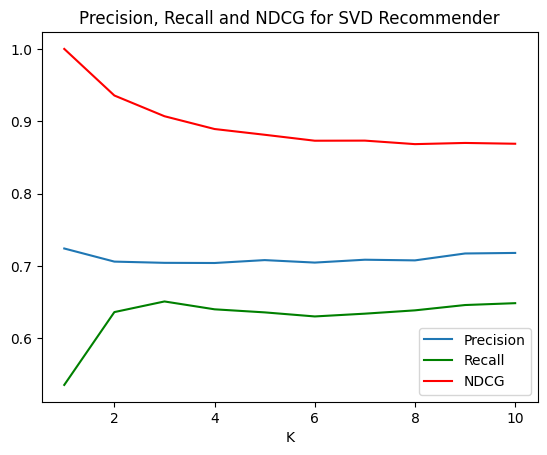

In [248]:
plt.plot(np.arange(1, len(surprise_svd_metrics['precision'])+1), surprise_svd_metrics['precision']);
plt.plot(np.arange(1,len(surprise_svd_recall)+1), surprise_svd_recall, color='g')
plt.plot(np.arange(1, len(surprise_svd_metrics['ndcg'])+1), surprise_svd_metrics['ndcg'], color='r');
plt.xlabel('K')
plt.title('Precision, Recall and NDCG for SVD Recommender')
plt.legend(["Precision", 'Recall', "NDCG"], loc="lower right");

In [171]:
type(surprise_svd_train)

surprise.trainset.Trainset

In [174]:
svd_train_data = Dataset.load_from_df(svd_train[["user_id", "business_id", "rating"]], reader)

In [175]:
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_epochs": [10, 30, 50],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6],
    'n_factors': [100,200, 250]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)


gs.fit(svd_train_data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.1295323617483588
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 100}


In [192]:
hyp_svd = SVD(random_state=0, n_epochs= 30, lr_all= 0.005, reg_all= 0.4, n_factors= 100, verbose=True)

In [193]:
hyp_svd.fit(surprise_svd_train)
surprise_svd_hyp_predictions = predict(hyp_svd, svd_test, usercol="user_id", itemcol="business_id")
surprise_svd_hyp_predictions = pd.merge(surprise_svd_hyp_predictions, svd_test, on=['user_id', 'business_id'])
surprise_svd_hyp_predictions.sort_values(by='prediction',ascending=False,inplace=True)
surprise_svd_hyp_predictions['y_actual'] = surprise_svd_hyp_predictions['rating'] >= threshold
surprise_svd_hyp_predictions['y_recommended'] = surprise_svd_hyp_predictions['prediction'] >= threshold
surprise_svd_hyp_predictions['hit'] = surprise_svd_hyp_predictions['y_actual'] & surprise_svd_hyp_predictions['y_recommended']
surprise_svd_hyp_predictions['hit'] = surprise_svd_hyp_predictions['hit'].apply(lambda x: 1 if x else 0)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


In [238]:
with open('hyp_svd.pickle', 'wb') as handle:
    pickle.dump(hyp_svd, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [194]:
surprise_svd_hyp_metrics = eval_metrics(surprise_svd_hyp_predictions, TOP_K)

In [243]:
ratings_sample.head()

,user_id,business_id,rating,date,text,business_name
0,0FbtB0ajpk8VZSVpC6KjGw,DqVpNtgFCP47n6frh-LREA,4.0,2005-03-22 20:43:35,This restaurant has got GREAT Mexican food and...,el paseo mexican restaurant
1,0FbtB0ajpk8VZSVpC6KjGw,AmAc0eD6lyVyb7QdOAO1Mg,4.0,2005-03-22 20:45:10,Soho is a great place to get a drink and watch...,soho restaurant & music club
2,0FbtB0ajpk8VZSVpC6KjGw,edJoBsse6nsF0BYh6pATAg,4.0,2005-03-22 20:48:23,This place is one of a kind. For great Cajun f...,the palace grill
3,0FbtB0ajpk8VZSVpC6KjGw,Un-UDVOuv1co3TMmGaumxA,5.0,2005-03-22 23:14:59,You CANNOT miss out on this place for breakfas...,shoreline beach cafe
4,c8qFkI_VusWo0xZvkjfBWQ,ecI3FBTM0f99Fnml3kNKfg,5.0,2005-05-15 00:07:04,Don't bother with the fancy dining where you n...,arnaud's restaurant


In [ ]:
surprise_svd_hyp_recall = recall_over_k(surprise_svd_hyp_predictions, TOP_K)

In [240]:
surprise_svd_hyp_metrics['mrr'], surprise_svd_hyp_metrics['map']

(0.7594230245088789, 0.7496299454272313)

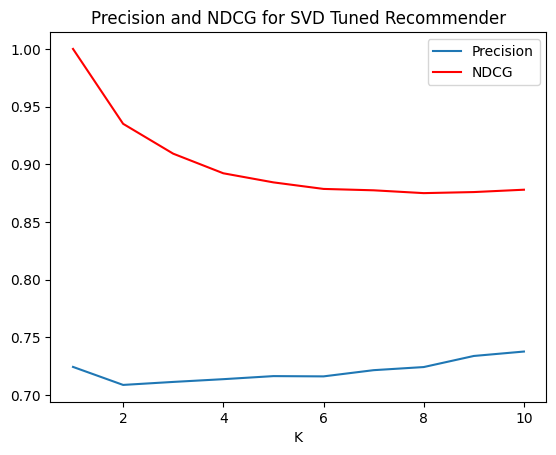

In [197]:
plt.plot(np.arange(1, len(surprise_svd_hyp_metrics['precision'])+1), surprise_svd_hyp_metrics['precision']);
plt.plot(np.arange(1, len(surprise_svd_hyp_metrics['ndcg'])+1), surprise_svd_hyp_metrics['ndcg'], color='r');
plt.xlabel('K')
plt.title('Precision and NDCG for SVD Tuned Recommender')
plt.legend(["Precision", "NDCG"], loc="upper right");